In [1]:
from kalman import Kalman
import numpy as np
import matplotlib.pyplot as plt

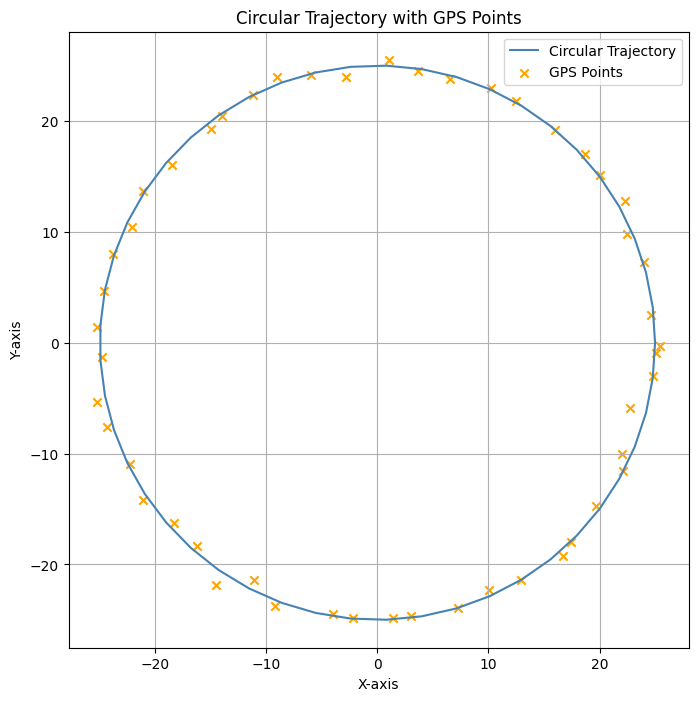

In [2]:
#create GPS data

nbr_sample_GPS = 50
# Generate time values for one turn (1 second)
time_values = np.linspace(0, 1, nbr_sample_GPS)

# Define the circular trajectory using sine and cosine functions
radius = 25
x_ref = radius * np.cos(2 * np.pi * time_values)
y_ref = radius * np.sin(2 * np.pi * time_values)

#white noise GPS
sigma_x_gps = 0.5
sigma_y_gps = 0.5

noise_x_GPS = sigma_x_gps*np.random.randn(nbr_sample_GPS)
noise_y_GPS = sigma_y_gps*np.random.randn(nbr_sample_GPS)

x_GPS = noise_x_GPS + x_ref
y_GPS = noise_y_GPS + y_ref

# Plot the circular trajectory and GPS points
plt.figure(figsize=(8, 8))
plt.plot(x_ref, y_ref, label='Circular Trajectory', color='steelblue')
plt.scatter(x_GPS, y_GPS, c='orange', marker='x', label='GPS Points')
plt.title('Circular Trajectory with GPS Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()



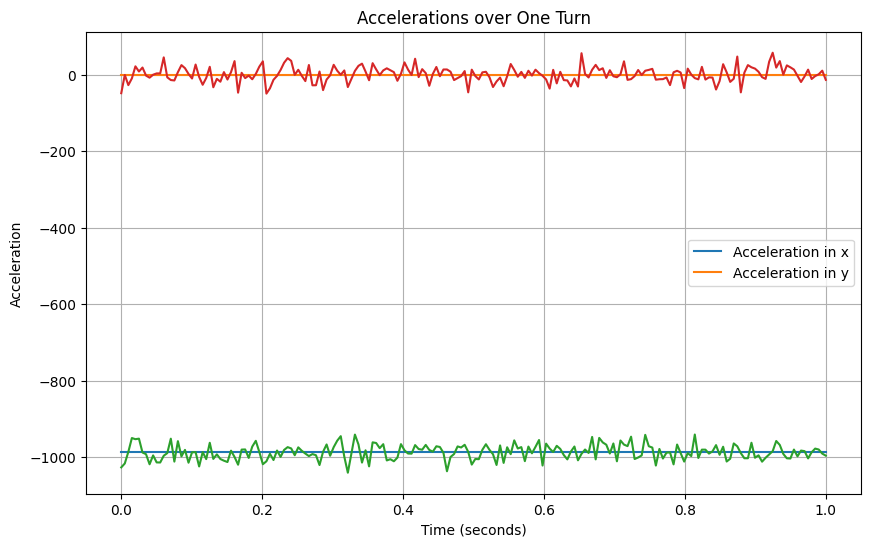

In [3]:


nbr_sample_acc = 200
# Generate time values for one turn (1 second)
time_values = np.linspace(0, 1, nbr_sample_acc)

def calculate_accelerations(t):
    a_x = -4*np.pi*np.pi *radius* np.cos(2 * np.pi * t)
    a_y = -4*np.pi*np.pi *radius*np.sin(2 * np.pi * t)
    return a_x, a_y

nbr_sample_acc = 200
# Generate time values for one turn (1 second)
time_values = np.linspace(0, 1, 200)

# Calculate accelerations for each time value
accelerations = np.array([calculate_accelerations(t) for t in time_values])

# Separate ax and ay values
a_x_values = accelerations[:, 0]
a_y_values = accelerations[:, 1]

a_x_values = -4*(np.pi**2)*radius*np.ones(nbr_sample_acc)
a_y_values =0*np.ones(nbr_sample_acc) 

sigma_white_noise= 20

noise_ax = sigma_white_noise*np.random.randn(nbr_sample_acc)
noise_ay = sigma_white_noise*np.random.randn(nbr_sample_acc)

ax_noisy = noise_ax + a_x_values
ay_noisy = noise_ay + a_y_values
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(time_values, a_x_values, label='Acceleration in x')
plt.plot(time_values, a_y_values, label='Acceleration in y')
plt.plot(time_values,ax_noisy)
plt.plot(time_values,ay_noisy)
plt.title('Accelerations over One Turn')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

#for the next steps we will use those names for acceleration components
accel_rw_x = ax_noisy
accel_rw_y = ay_noisy

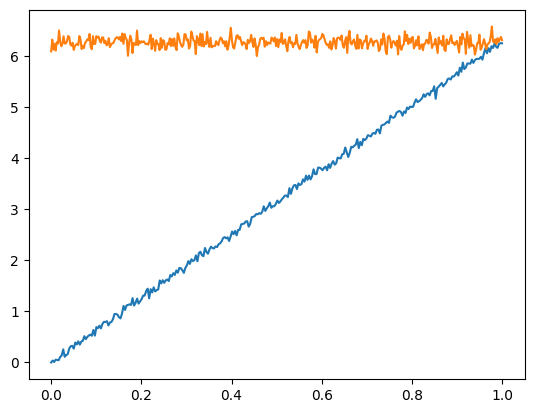

In [4]:
#create rotation data
#kalman for orientation
omega = 2*np.pi

# generate measurements
n_sample_omega = 400
n_sample_theta = 300
omega_x = np.linspace(0,1,n_sample_omega)
omega = np.ones(n_sample_omega)*omega
sigma_omega = 0.1
omega_noise = sigma_omega*np.random.randn(n_sample_omega)
omega_noise += omega


# Generate an array of angles from 0 to 2*pi
theta_x = np.linspace(0, 1, n_sample_theta)
theta = 2*np.pi* theta_x

# Add random noise
sigma_theta = 0.05
theta_noise = sigma_theta * np.random.randn(n_sample_theta)
theta_noise = theta + theta_noise

# Plot the line
plt.plot(theta_x,theta_noise)
plt.plot(omega_x,omega_noise)
plt.show()

# Generate timestamps for 200 Hz and 100 Hz arrays
timestamps_theta = np.arange(len(theta_noise))   # Timestamps for accelerometer
timestamps_theta = timestamps_theta/timestamps_theta[-1]
timestamps_omega = np.arange(len(omega))   # Timestamps for GPS
timestamps_omega = timestamps_omega/timestamps_omega[-1]
sigma_timestamps = 0.0001

# Add small noise to the timestamps
noise_omega = np.random.normal(0, sigma_timestamps, len(timestamps_omega)) # Adjust the standard deviation as needed
timestamps_omega = timestamps_omega + noise_omega
noise_theta = np.random.normal(0, sigma_timestamps, len(timestamps_theta))
timestamps_theta = timestamps_theta + noise_theta

timestamps_omega = np.sort(timestamps_omega)
timestamps_theta = np.sort(timestamps_theta)

In [5]:
# Generate timestamps for GPS and acceleration
timestamps_acc = np.arange(len(accel_rw_x))   # Timestamps for accelerometer
timestamps_acc = timestamps_acc/timestamps_acc[-1]
timestamps_gps = np.arange(len(x_GPS))   # Timestamps for GPS
timestamps_gps = timestamps_gps/timestamps_gps[-1]
sigma_timestamps = 0.0001

# Add small noise to the timestamps
noise_acc = np.random.normal(0, sigma_timestamps, len(timestamps_acc)) # Adjust the standard deviation as needed
timestamps_acc_y = timestamps_acc + noise_acc
noise_acc = np.random.normal(0, sigma_timestamps, len(timestamps_acc))
timestamps_acc_x = timestamps_acc + noise_acc
noise_gps = np.random.normal(0, sigma_timestamps, len(timestamps_gps))
timestamps_gps_x = timestamps_gps + noise_gps
noise_gps = np.random.normal(0, sigma_timestamps, len(timestamps_gps))
timestamps_gps_y = timestamps_gps + noise_gps

timestamps_acc_y = np.sort(timestamps_acc_y)
timestamps_acc_x = np.sort(timestamps_acc_x)
timestamps_gps_x = np.sort(timestamps_gps_x)
timestamps_gps_y = np.sort(timestamps_gps_y)


timestamps_gps_x = np.concatenate((timestamps_gps_x[:20], timestamps_gps_x[30+1:]))
timestamps_gps_y = np.concatenate((timestamps_gps_y[:20], timestamps_gps_y[30+1:]))

x_GPS = np.concatenate((x_GPS[:20], x_GPS[30+1:]))
y_GPS  = np.concatenate((y_GPS[:20], y_GPS[30+1:]))

timestamps_copy_x = timestamps_gps_x
timestamps_copy_y = timestamps_gps_y

In [6]:
kf_robot = Kalman(position=[x_GPS[0],y_GPS[0]],acceleration=[ax_noisy[0],
                    ay_noisy[0]],velocity=[0,157])
timestamps_theta = timestamps_theta[1:]
timestamps_omega = timestamps_omega[1:]
omega_noise_copy = omega_noise[1:]
theta_noise_copy = theta_noise[1:]

accel_rw_x_copy = ax_noisy[1:]
accel_rw_y_copy = ay_noisy[1:]
x_GPS_copy = x_GPS[1:]
y_GPS_copy = y_GPS[1:]


timestamps_acc_x = timestamps_acc_x[1:]
timestamps_gps_x = timestamps_gps_x[1:]
timestamps_theta = timestamps_theta[1:]
timestamps_omega = timestamps_omega[1:]
pos = []
heading = []
while len(timestamps_acc_x) > 1 and len(timestamps_omega) > 1 and len(timestamps_theta)>1 and len(timestamps_gps)>1:
    if timestamps_acc_x[0]<timestamps_omega[0] and timestamps_acc_x[0]<timestamps_gps_x[0] and timestamps_acc_x[0]<timestamps_theta[0]:
        kf_robot.update_acceleration([accel_rw_x_copy[0],accel_rw_y_copy[0]],timestamps_acc_x[0])
        timestamps_acc_x = timestamps_acc_x[1:]
        accel_rw_x_copy = accel_rw_x_copy[1:]
        accel_rw_y_copy = accel_rw_y_copy[1:]
        pos.append(kf_robot.get_position()[:])

    elif timestamps_omega[0]<timestamps_gps_x[0] and timestamps_omega[0]<timestamps_theta[0]:
        kf_robot.update_spin(omega_noise_copy[0],timestamps_omega[0])
        omega_noise_copy = omega_noise_copy[1:]
        timestamps_omega = timestamps_omega[1:]
        heading.append(kf_robot.get_rotation())

    elif timestamps_gps_x[0]<timestamps_theta[0]:
        kf_robot.update_position([x_GPS_copy[0],y_GPS_copy[0]],timestamps_gps_x[0])
        x_GPS_copy = x_GPS_copy[1:]
        y_GPS_copy = y_GPS_copy[1:]
        timestamps_gps_x = timestamps_gps_x[1:]
        pos.append(kf_robot.get_position()[:])
    else:
        kf_robot.update_heading(theta_noise_copy[0],timestamps_theta[0])
        theta_noise_copy = theta_noise_copy[1:]
        timestamps_theta = timestamps_theta[1:]
        heading.append(kf_robot.get_rotation())

heading = np.array(heading)
pos = np.array(pos)


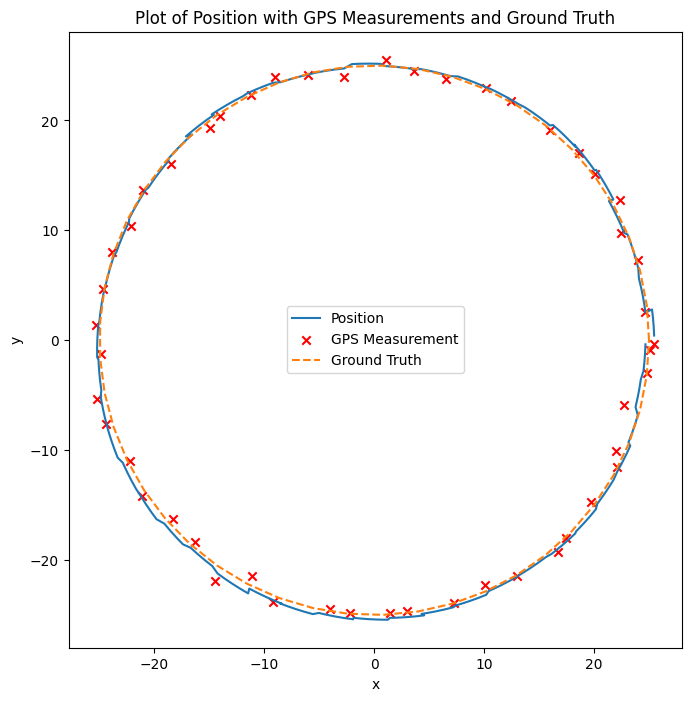

In [7]:
# Extracting individual columns

posx = pos[:,0]
posy = pos[:,1]

# Plotting positions
plt.figure(figsize=(8, 8))
plt.plot(posx, posy, label='Position')

# Plotting GPS measurements
plt.scatter(x_GPS, y_GPS, marker='x', color='red', label='GPS Measurement')

# Plotting ground truth
plt.plot(x_ref, y_ref, '--', label='Ground Truth')

plt.title('Plot of Position with GPS Measurements and Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

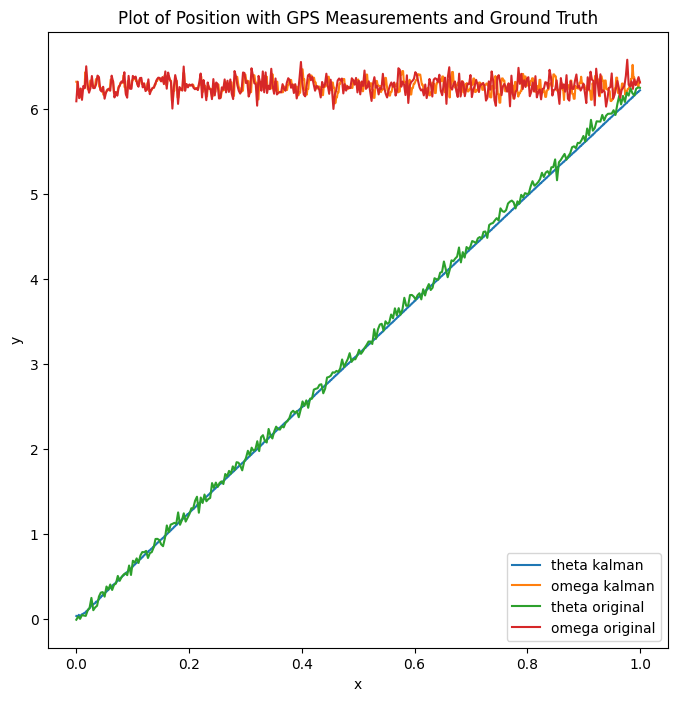

In [8]:
# Extracting individual columns
xs = np.array(heading)
theta_kalman = xs[:, 0]
omega_kalman = xs[:, 1]
x_values = np.linspace(0,1,len(omega_kalman))
# Plotting 
plt.figure(figsize=(8, 8))
plt.plot(x_values,theta_kalman, label='theta kalman')
plt.plot(x_values,omega_kalman, label='omega kalman')
plt.plot(theta_x,theta_noise,label='theta original')
plt.plot(omega_x,omega_noise,label='omega original')

plt.title('Plot of Position with GPS Measurements and Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()